### Машинное обучение
## Домашнее задание №3 - Градиентный бустинг

**Общая информация**

**Срок сдачи:** 16 февраля 2023, 08:30   
**Штраф за опоздание:** -2 балла за каждые сутки

Используйте данный Ipython Notebook при оформлении домашнего задания.

##  Считаем производные для функций потерь (1 балл)

Мы будем реализовать градиентный бустинг для 3 функций потерь:

1) MSE  $L(a(x_i), y_i) = (y_i - a(x_i)) ^ 2$

2) Экспоненциальная  $L(a(x_i), y_i) = exp( -a(x_i) y_i), y_i \in \{-1, 1\}$

3) Логистическая  $L(a(x_i), y_i) = \log (1 + exp( -a(x_i) y_i)), y_i \in \{-1, 1\}$

где $a(x_i)$ предсказание бустинга на итом объекте. 

Для каждой функции потерь напишите таргет, на который будет настраиваться каждое дерево в бустинге. 

В бустингах будем обучаться на антиградиент $-dL(a(x_i), y_i)$
1) $-dL(a(x_i), y_i) = 2(y_i - a(x_i))\cdot da(x_i)$ \
2) $-dL(a(x_i), y_i) = exp(-a(x_i) y_i)y_i\cdot da(x_i)$ \
3) $-dL(a(x_i), y_i) = \dfrac{exp(-a(x_i) y_i)y_i\cdot da(x_i)}{1 + exp( -a(x_i) y_i)}$

##  Реализуем градиентный бустинг (3 балла)

Реализуйте класс градиентного бустинга для классификации. Ваша реализация бустинга должна работать по точности не более чем на 5 процентов хуже чем GradientBoostingClassifier из sklearn. 


Детали реализации:

-- должно поддерживаться 3 функции потерь

-- сами базовые алгоритмы(деревья, линейные модели и тп) реализовать не надо, просто возьмите готовые из sklearn

-- в качестве функции потерь для построения одного дерева используйте MSE

-- шаг в бустинге можно не подбирать, можно брать константный

-- можно брать разные модели в качестве инициализации бустинга

-- должны поддерживаться следующие параметры:

а) число итераций
б) размер шага
в) процент случайных фичей при построении одного дерева
д) процент случайных объектов при построении одного дерева
е) параметры базового алгоритма (передавайте через **kwargs)

In [97]:
import numpy as np
from scipy import stats
from tqdm import tqdm
import matplotlib.pyplot as plt

from sklearn.datasets import load_wine
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor

Ремарка: я точно знаю основы анализа и дифференцирования, но эта шляпа ведет себя странно. Если брать антиградиент как надо, то алгоритм расходится. Если брать с минусом, то он начинает сходится, но по сути это становится градиентом. Мб я где-то чего-то не доглядел

In [98]:
class MSE:
    def loss(self, y_true, y_pred):
        return np.sum((y_true - y_pred) ** 2)
    
    def grad(self, y_true, y_pred):
        return 2 * (y_true - y_pred)
 

class Exponential:
    def loss(self, y_true, y_pred):
        return np.sum(np.exp(-y_pred * y_true))
    
    def grad(self, y_true, y_pred):
        return np.exp(-y_pred * y_true) * y_true
    

class Logarithmic:
    def loss(self, y_true, y_pred):
        return np.sum(np.log(1 + np.exp(-y_pred * y_true)))
    
    def grad(self, y_true, y_pred):
        return (np.exp(-y_pred * y_true) * y_true) / (1 + np.exp(-y_pred * y_true))

In [99]:
class MyGradientBoostingClassifier:

    def __init__(self, loss='MSE', learning_rate=1e-1, n_estimators=100, colsample=0.7, subsample=0.7, random_state=None, *args, **kwargs):
        """
        loss -- один из 3 лоссов:
        learning_rate -- шаг бустинга
        n_estimators -- число итераций
        colsample -- процент рандомных признаков при обучнеии одного алгоритма
        subsample -- процент рандомных объектов при обучнеии одного алгоритма
        args, kwargs -- параметры  базовых моделей
        """
        # Ваш код здесь
        loss_dict = {
            'mse' : MSE(),
            'exp' : Exponential(),
            'log' : Logarithmic()
        }
        
        # будем хранить пары (модель, фичи)
        self.models = []
        self.features_ids = []
        self.random_state = random_state
        
        self.criterion = loss_dict[loss]
        self.lr = learning_rate
        self.n_estimators = n_estimators
        
        self.colsample = colsample
        self.subsample = subsample
        
        self.args = args
        self.kwargs = kwargs
        
    
    def fit(self, X, y, base_model=DecisionTreeRegressor, init_model=None):
        """
        X -- объекты для обучения:
        y -- таргеты для обучения
        base_model -- класс базовых моделей, например sklearn.tree.DecisionTreeRegressor
        init_model -- класс для первой модели, если None то берем константу (только для посл задания)
        """
        # Ваш код здесь
        if init_model == None:
            # выбираем случайную константу
            #const_pred = y[np.random.choice(y, 1)]
            const_pred = stats.mode(y, keepdims=True)[0]
            # готовим таргет для бустинга
            y_boosting = (-1) * self.criterion.grad(y, const_pred)
            # сохраняем
            self.models.append(const_pred)
            if self.random_state == None:
                self.models += [base_model(*self.args, **self.kwargs) for i in range(1, self.n_estimators)]
            else:
                self.models += [base_model(random_state = self.random_state, *self.args, **self.kwargs) for i in range(1, self.n_estimators)]
            self.features_ids.append(None)
            
        else:
            # инициализируем выданную модель
            if self.random_state == None:
                start_model = init_model(*self.args, **self.kwargs)
            else:
                start_model = init_model(random_state = self.random_state, *self.args, **self.kwargs)
            # отбираем фичи и объекты
            features_id = np.random.choice(X.shape[1], int(self.colsample * X.shape[1]))
            samples_id = np.random.choice(X.shape[0], int(self.subsample * X.shape[0]))
            # берем подвыборку
            X_train = X[samples_id][:, features_id]
            y_train = y[samples_id]
            # учим на подвыборке
            start_model.fit(X_train, y_train)
            # сохраняем
            self.models.append(start_model)
            if self.random_state == None:
                self.models += [base_model(*self.args, **self.kwargs) for i in range(1, self.n_estimators)]
            else:
                self.models += [base_model(random_state = self.random_state, *self.args, **self.kwargs) for i in range(1, self.n_estimators)]
            self.features_ids.append(features_id)
            # подготовим таргет для следующих моделей
            y_boosting = (-1) * self.criterion.grad(self.predict(X), y)
            # таргеты, которые не затронуло оставим прежними
            #y_boosting = y.copy()
            #y_boosting[samples_id] = boosting_target
            
        for i, boosting_model in enumerate(self.models[1:]):
            # инициализация новой модели
            # boosting_model = base_model(*self.args, **self.kwargs)
            # выбираем фичи и объекты
            features_id = np.random.choice(X.shape[1], int(self.colsample * X.shape[1]))
            samples_id = np.random.choice(X.shape[0], int(self.subsample * X.shape[0]))
            # берем подвыборку
            X_train = X[samples_id][:, features_id]
            y_train = y_boosting[samples_id]
            # учим
            boosting_model.fit(X_train, y_train)
            # сохраняем
            #self.models.append((boosting_model, features_id))
            self.features_ids.append(features_id)
            #print(f"Train {i} loss: {self.criterion.loss(self.predict(X), y)} | accuracy: {accuracy_score(y_pred=np.around(self.predict(X)).astype(int), y_true=y)}")
            
            # готовим новые таргеты
            y_boosting = (-1) * self.criterion.grad(self.predict(X), y)
            # корректируем все таргеты
            #y_boosting[samples_id] = boosting_target

    
    def predict(self, X):
        # Ваш код здесь
        if self.features_ids[0] is None:
            # константный прогноз
            pred = self.models[0]
        else:
            # достаем модель
            model = self.models[0]
            # достаем фичи, на которых она работает
            features_id = self.features_ids[0]
            # делаем предсказание
            pred = model.predict(X[:, features_id])
            
        for i in range(1, len(self.features_ids)):
            # достаем модель
            model = self.models[i]
            # достаем фичи, на которых она работает
            features_id = self.features_ids[i]
            # смещаем предсказание
            pred = pred + self.lr * model.predict(X[:, features_id])
        
        return pred


In [4]:
my_clf = MyGradientBoostingClassifier(loss='mse', 
                                      learning_rate=1e-1, 
                                      n_estimators=100, 
                                      colsample=0.7, 
                                      subsample=0.7,
                                      random_state=123
                                     )
clf = GradientBoostingClassifier(random_state=123)

In [5]:
wine = load_wine()
X_train, X_test, y_train, y_test = train_test_split(wine.data, wine.target, test_size=0.1, stratify=wine.target)

In [6]:
my_clf.fit(X_train, y_train)
clf.fit(X_train, y_train)
print(accuracy_score(y_pred=clf.predict(X_test), y_true=y_test))
print(accuracy_score(y_pred=np.round(my_clf.predict(X_test)).astype(int), y_true=y_test))

0.9444444444444444
1.0


## Подбираем параметры (2 балла)

Давайте попробуем применить Ваш бустинг для предсказаний цены домов в Калифорнии. Чтобы можно было попробовтаь разные функции потерь, переведем по порогу таргет в 2 класса: дорогие и дешевые дома.

В задании нужно

1) Построить график точности в зависимости от числа итераций на валидации.

2) Подобрать оптимальные параметры Вашего бустинга на валидации. 


In [100]:
from sklearn.datasets import fetch_california_housing
X, y = fetch_california_housing(return_X_y=True)

In [101]:
# Превращаем регрессию в классификацию
y = (y > 2.0).astype(int)
print(X.shape, y.shape)

(20640, 8) (20640,)


In [102]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

n_estimators_range = [i for i in range(100, 300, 50)] 
loss_plot = {
    'mse' : [],
    'exp' : [],
    'log' : []}

In [42]:
for loss_type in loss_plot.keys():
    with tqdm(n_estimators_range) as t:
        for n_estimators in t:
            if loss_type == 'mse':
                my_clf = MyGradientBoostingClassifier(loss=loss_type, 
                                                      learning_rate=1e-1, 
                                                      n_estimators=n_estimators, 
                                                      colsample=1.0, 
                                                      subsample=1.0,
                                                      random_state=123)
            else:
                my_clf = MyGradientBoostingClassifier(loss=loss_type, 
                                                      learning_rate=1e-3, 
                                                      n_estimators=n_estimators, 
                                                      colsample=1.0, 
                                                      subsample=1.0,
                                                      random_state=123)
            my_clf.fit(X_train, y_train)
            pred = np.around(my_clf.predict(X_test)).astype(int)
            score = accuracy_score(y_pred=np.round(my_clf.predict(X_test)).astype(int), y_true=y_test)
            t.set_description(f"{loss_type} | accuracy: {np.round(score, 3)} n: {n_estimators}")
            loss_plot[loss_type].append(score)

mse | accuracy: 0.864 n: 250: 100%|█████████████████████████████████| 4/4 [15:29<00:00, 232.44s/it]
exp | accuracy: 0.578 n: 250: 100%|█████████████████████████████████| 4/4 [08:21<00:00, 125.50s/it]
log | accuracy: 0.578 n: 250: 100%|█████████████████████████████████| 4/4 [07:50<00:00, 117.53s/it]


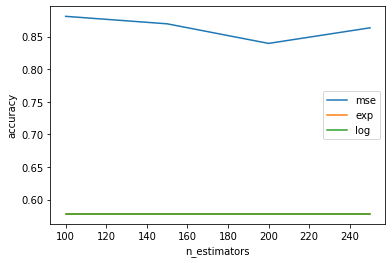

In [43]:
plt.xlabel('n_estimators')
plt.ylabel('accuracy')

for loss_type in loss_plot.keys():
    plt.plot(n_estimators_range, loss_plot[loss_type], label=loss_type)
    
plt.legend()
plt.show()

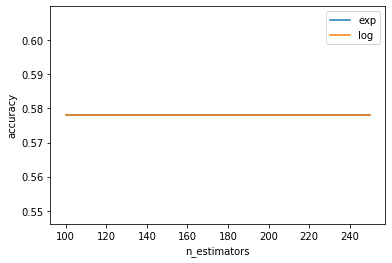

In [44]:
plt.xlabel('n_estimators')
plt.ylabel('accuracy')

for loss_type in list(loss_plot.keys())[1:]:
    plt.plot(n_estimators_range, loss_plot[loss_type], label=loss_type)
    
plt.legend()
plt.show()

Как пел Виктор Цой: "Странное дело...". Что имеем? MSE стабильней всех остальных, подберем параметры

In [47]:
my_clf = MyGradientBoostingClassifier(loss='mse', 
                                      learning_rate=1e-1, 
                                      n_estimators=150, 
                                      colsample=0.8, 
                                      subsample=0.8,
                                      random_state=123)

my_clf.fit(X_train, y_train)

pred = np.around(my_clf.predict(X_test)).astype(int)
score = accuracy_score(y_pred=np.round(my_clf.predict(X_test)).astype(int), y_true=y_test)
print(f"accuracy: {np.round(score, 3)}")

accuracy: 0.835


По итогу буду пробовать брать 150 итераций и отбирать по 80% случайных фичей и объектов выборки

## BooBag BagBoo (1 балл)



Попробуем объединить бустинг и бэгинг. Давайте

1) в качестве базовой модели брать не дерево решений, а случайный лес (из sklearn)

2) обучать N бустингов на бустрапированной выборке, а затем предикт усреднять

Попробуйте обе этих стратегии на данных из прошлого задания. Получилось ли улучшить качество? Почему?

New init

In [48]:
from sklearn.ensemble import RandomForestClassifier


my_clf = MyGradientBoostingClassifier(loss='mse', 
                                      learning_rate=1e-1, 
                                      n_estimators=150, 
                                      colsample=0.8, 
                                      subsample=0.8,
                                      random_state=123)

my_clf.fit(X_train, y_train, init_model=RandomForestClassifier)

pred = np.around(my_clf.predict(X_test)).astype(int)
score = accuracy_score(y_pred=np.round(my_clf.predict(X_test)).astype(int), y_true=y_test)
print(f"accuracy: {np.round(score, 3)}")

accuracy: 0.865


Boosting & bagging

In [75]:
n_boostings = 10

pred = []
bootstrap_size = X.shape[0]
bagging_ensemble = []

for i in tqdm(range(n_boostings)):
    bootstrap_idx = np.random.choice(range(X_train.shape[0]), replace=True, size=bootstrap_size)
    X_bootstrap, y_bootstrap = X_train[bootstrap_idx], y_train[bootstrap_idx]
    
    my_clf = MyGradientBoostingClassifier(loss='mse', 
                                      learning_rate=1e-1, 
                                      n_estimators=100, 
                                      colsample=0.8, 
                                      subsample=0.8,
                                      random_state=123)

    my_clf.fit(X_bootstrap, y_bootstrap)
    bagging_ensemble.append(my_clf)
    pred.append(my_clf.predict(X_test))

100%|██████████████████████████████████████████████████████████████| 10/10 [09:44<00:00, 58.41s/it]


In [78]:
pred = np.array(pred)

pred_mean = np.mean(pred, axis=0)
pred_mode = stats.mode(np.round(pred).astype(int), keepdims=False)[0]
pred_median = np.median(np.round(pred).astype(int), axis=0)

score_mean = accuracy_score(y_pred=np.round(pred_mean).astype(int), y_true=y_test)
score_mode = accuracy_score(y_pred=np.round(pred_mode).astype(int), y_true=y_test)
score_median = accuracy_score(y_pred=np.round(pred_median).astype(int), y_true=y_test)

print(f"Accuracy| mean: {np.round(score_mean, 5)} mode: {np.round(score_mode, 5)} median: {np.round(score_median, 5)}")

Accuracy| mean: 0.8876 mode: 0.88485 median: 0.88485


Идею с бэгингом я сперва не особо воспринял, но потом решил сделать выборку размером с весь датасет. При этом еще вывел разные варианты аггрегации предиктов. Результаты получились интересные =)\
Инциализация случайным лесом - интересная тема. Получается на старте мы как бы пытаемся выбить хороший скор, а потом дообучаем бустингом, красивая стратегия.\

Overall, результаты получились повыше. У бэггинга за счет комбинации моделей (ошибка становится маловероятным событием, ибо ошибиться должны несколько моделей разом), у инициализации прирост за счет хорошего начального приближения случайным лесом

## Умная инициализация (1 балл)

Попробуйте брать в качестве инициализации бустинга не константу, а какой-то алгоритм и уже от его предикта стартовать итерации бустинга. Попробуйте разные модели из sklearn: линейные модели, рандом форест, svm..

Получилось ли улучшить качество? Почему?



RandomForest

In [81]:
my_clf = MyGradientBoostingClassifier(loss='mse', 
                                      learning_rate=1e-1, 
                                      n_estimators=150, 
                                      colsample=0.8, 
                                      subsample=0.8,
                                      random_state=123)

my_clf.fit(X_train, y_train, init_model=RandomForestClassifier)

pred = np.around(my_clf.predict(X_test)).astype(int)
score = accuracy_score(y_pred=np.round(my_clf.predict(X_test)).astype(int), y_true=y_test)
print(f"accuracy: {np.round(score, 7)}")

accuracy: 0.8645026


DecisionTree

In [82]:
my_clf = MyGradientBoostingClassifier(loss='mse', 
                                      learning_rate=1e-1, 
                                      n_estimators=150, 
                                      colsample=0.8, 
                                      subsample=0.8,
                                      random_state=123)

my_clf.fit(X_train, y_train, init_model=DecisionTreeRegressor)

pred = np.around(my_clf.predict(X_test)).astype(int)
score = accuracy_score(y_pred=np.round(my_clf.predict(X_test)).astype(int), y_true=y_test)
print(f"accuracy: {np.round(score, 7)}")

accuracy: 0.7703488


LinearRegression

In [85]:
from sklearn.linear_model import LinearRegression


my_clf = MyGradientBoostingClassifier(loss='mse', 
                                      learning_rate=1e-1, 
                                      n_estimators=150, 
                                      colsample=0.8, 
                                      subsample=0.8)

my_clf.fit(X_train, y_train, init_model=LinearRegression)

pred = np.around(my_clf.predict(X_test)).astype(int)
score = accuracy_score(y_pred=np.round(my_clf.predict(X_test)).astype(int), y_true=y_test)
print(f"accuracy: {np.round(score, 7)}")

accuracy: 0.8661176


Ridge Regression

In [105]:
from sklearn.linear_model import Ridge


my_clf = MyGradientBoostingClassifier(loss='mse', 
                                      learning_rate=1e-1, 
                                      n_estimators=150, 
                                      colsample=0.7, 
                                      subsample=0.7)

my_clf.fit(X_train, y_train, init_model=Ridge)

pred = np.around(my_clf.predict(X_test)).astype(int)
score = accuracy_score(y_pred=np.round(my_clf.predict(X_test)).astype(int), y_true=y_test)
print(f"accuracy: {np.round(score, 7)}")

accuracy: 0.8465762


In [106]:
from sklearn.linear_model import LogisticRegression


my_clf = MyGradientBoostingClassifier(loss='mse', 
                                      learning_rate=1e-1, 
                                      n_estimators=150, 
                                      colsample=0.7, 
                                      subsample=0.7)

my_clf.fit(X_train, y_train, init_model=LogisticRegression)

pred = np.around(my_clf.predict(X_test)).astype(int)
score = accuracy_score(y_pred=np.round(my_clf.predict(X_test)).astype(int), y_true=y_test)
print(f"accuracy: {np.round(score, 7)}")

accuracy: 0.8617571


In [107]:
from sklearn.linear_model import ElasticNet


my_clf = MyGradientBoostingClassifier(loss='mse', 
                                      learning_rate=1e-1, 
                                      n_estimators=150, 
                                      colsample=0.7, 
                                      subsample=0.7)

my_clf.fit(X_train, y_train, init_model=ElasticNet)

pred = np.around(my_clf.predict(X_test)).astype(int)
score = accuracy_score(y_pred=np.round(my_clf.predict(X_test)).astype(int), y_true=y_test)
print(f"accuracy: {np.round(score, 7)}")

accuracy: 0.8439922


Хорошее качество у RandomForest и LinearRegression. RandomForest в принципе классный алгоритм, а вот DecisionTree наверное слабее ансамбля и поэтому уступает. Регрессии клево себя показали ибо в задаче два класса. По итогу, победила модель с инициализацией через LinearRegression

| Model | Accuracy |
|---|---|
| RandomForest | 0.8645026 |
| DecisionTree | 0.7703488 |
| LinearRegression | 0.8661176 |
| RidgeRegression | 0.8465762 |
| LogisticRegression | 0.8617571 |
| ElasticNet | 0.8439922 |

## Фидбек (бесценно)

* Какие аспекты обучения  ансамблей Вам показались непонятными? Какое место стоит дополнительно объяснить?

### Ваш ответ здесь

Все было клево, но вот почему у меня пошли странности с антиградиентом - загадка. Хотел бы получить фидбек что я сделал не так. Там же наверное кроется причина почему у меня точность моделей на log и exp лоссах была постоянной на уровне 0.578 =)

### ВАШ ОТЗЫВ ЗДЕСЬ

